In [13]:
import copy
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
neuraltextures_df = pd.read_csv("../dataset/neuraltextures_train_test_val_2.csv", index_col = 0)

In [15]:
real_youtube_df = pd.read_csv("../dataset/real_youtube_train_test_val.csv", index_col = 0)

In [16]:
fake_df = neuraltextures_df

In [17]:
real_df = real_youtube_df

In [18]:
print(fake_df.groupby('train')['path_drive'].agg('count'))

train
test          1275
train         4301
validation    1065
Name: path_drive, dtype: int64


In [19]:
print(real_df.groupby('train')['path_drive'].agg('count'))

train
test          1468
train         4772
validation    1216
Name: path_drive, dtype: int64


In [20]:
def get_ttv_xy(fake_df, real_df):
    fake_train = fake_df[fake_df['train_fixed'] == 'train']
    real_train = real_df[real_df['train'] == 'train']
    fake_test = fake_df[fake_df['train_fixed'] == 'test']
    real_test = real_df[real_df['train'] == 'test']
    fake_val = fake_df[fake_df['train_fixed'] == 'validation']
    real_val = real_df[real_df['train'] == 'validation']
    x_train = np.concatenate((fake_train.iloc[:,:-3].values, real_train.iloc[:,:-2].values), axis=0)
    y_train = np.concatenate((np.ones(fake_train.shape[0]), np.zeros(real_train.shape[0])))
    x_test = np.concatenate((fake_test.iloc[:,:-3].values, real_test.iloc[:,:-2].values), axis=0)
    y_test = np.concatenate((np.ones(fake_test.shape[0]), np.zeros(real_test.shape[0])))
    x_val = np.concatenate((fake_val.iloc[:,:-3].values, real_val.iloc[:,:-2].values), axis=0)
    y_val = np.concatenate((np.ones(fake_val.shape[0]), np.zeros(real_val.shape[0])))
    return x_train, x_test, x_val, y_train, y_test, y_val
    

In [21]:
def shuffle_two_arrays(arr1, arr2):
    shuffler = np.random.permutation(len(arr1))
    array1_shuffled = arr1[shuffler]
    array2_shuffled = arr2[shuffler]

    return array1_shuffled, array2_shuffled

In [22]:
x_train, x_test, x_val, y_train, y_test, y_val = get_ttv_xy(fake_df, real_df)

In [23]:
x_train, y_train = shuffle_two_arrays(x_train, y_train)

In [24]:
x_test, y_test = shuffle_two_arrays(x_test, y_test)

In [25]:
x_val, y_val = shuffle_two_arrays(x_val, y_val)

In [26]:
def demeaning_local(array_nd):
    array_nd = array_nd.astype('float32')
    means = array_nd.mean(axis=(0,1,2), dtype='float64')
    #print('Means: %s' % means)
    #print(means.shape)
    array_nd -= means
    return array_nd

In [27]:
def demeaning_global(arr):
    mean = arr.mean()
    print('Mean: %.3f' % mean)
    arr_0mean = arr - mean
    return arr_0mean

In [28]:
#nd_array = np.reshape(flat_array, (40, 40, 4, 3))
x_train_4d = np.reshape(x_train, (x_train.shape[0],40,40,4,3))
x_train_4d_demean = demeaning_local(x_train_4d)
x_train_flat = x_train_4d_demean.reshape((x_train.shape[0], 40*40*4*3))

In [29]:
x_test_4d = np.reshape(x_test, (x_test.shape[0],40,40,4,3))
x_test_4d_demean = demeaning_local(x_test_4d)
x_test_flat = x_test_4d_demean.reshape((x_test.shape[0], 40*40*4*3))

In [30]:
x_val_4d = np.reshape(x_val, (x_val.shape[0],40,40,4,3))
x_val_4d_demean = demeaning_local(x_val_4d)
x_val_flat = x_val_4d_demean.reshape((x_val.shape[0], 40*40*4*3))

In [31]:


x_val_flat = x_val.reshape((x_val.shape[0], 40*40*4*3))

x_test_flat = x_test.reshape((x_test.shape[0], 40*40*4*3))


from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver = 'saga', max_iter = 1000, tol =0.001)
logit = logisticRegr.fit(x_train_flat, y_train)

# training and test accuracy
print('training acc: {:.2f}'.format(logit.score(x_train_flat, y_train)))
print('test acc: {:.2f}'.format(logit.score(x_test_flat, y_test)))
print('validation acc: {:.2f}'.format(logit.score(x_val_flat, y_val)))

training acc: 0.78
test acc: 0.59
validation acc: 0.60


In [45]:
model_path = "logit_neuraltextures.pickle"
import pickle
with open(model_path, 'wb') as fout:
    pickle.dump(logit, fout)

In [32]:
y_test_pred =logit.predict(x_test_flat)
y_val_pred = logit.predict(x_val_flat)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.58      0.60      1468
         1.0       0.55      0.60      0.58      1280

    accuracy                           0.59      2748
   macro avg       0.59      0.59      0.59      2748
weighted avg       0.59      0.59      0.59      2748



In [34]:
print(confusion_matrix(y_test, y_test_pred, labels=[0,1]))
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])

[[850 618]
 [511 769]]


In [35]:
!pip install seaborn

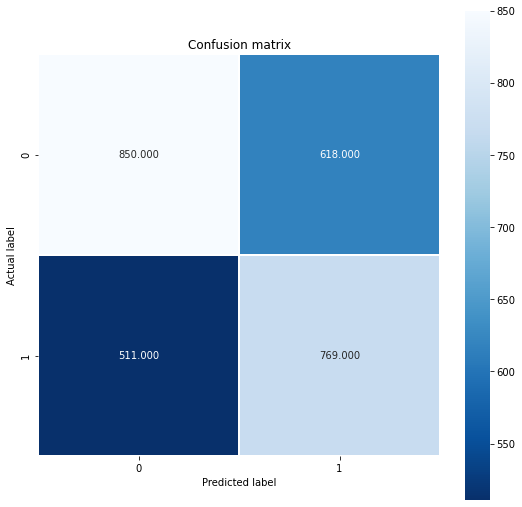

In [36]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logit.score)
plt.title("Confusion matrix");

In [37]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63      1216
         1.0       0.58      0.56      0.57      1072

    accuracy                           0.60      2288
   macro avg       0.60      0.60      0.60      2288
weighted avg       0.60      0.60      0.60      2288



In [38]:
print(logit.coef_)
print(logit.coef_.shape)
coef_lr = logit.coef_.reshape(-1)
print(coef_lr.shape)
coef_lr_abs = np.abs(coef_lr)
coef_lr_0_1 = np.interp(coef_lr_abs, (coef_lr.min(), coef_lr.max()), (0, 1))
coef_lr_split_0_1 = np.array_split(coef_lr_0_1, 4)

[[ 0.00023619 -0.0005415   0.00018071 ...  0.00109736 -0.00042371
   0.00059139]]
(1, 19200)
(19200,)


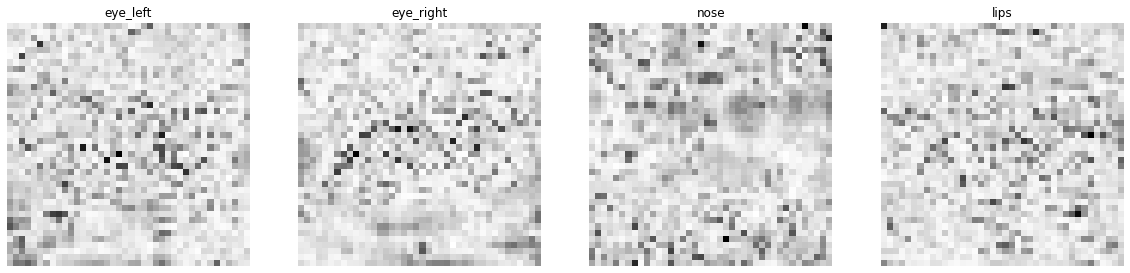

In [39]:
coef_lr_0_1_3mean = np.mean(coef_lr_0_1.reshape(-1, 3), axis=1)
coef_lr_split_0_1_3mean = np.array_split(coef_lr_0_1_3mean, 4)
feat = ['eye_left', 'eye_right', 'nose', 'lips']
plt.rcParams['figure.figsize'] = (20.0, 16.0)
for i in range(4):
    plt.subplot(1,4,i+1)
    img_color = coef_lr_split_0_1_3mean[i]
    img_color = img_color.reshape((40,40))
    #img_gray = np.dot(img_color, [0.299, 0.587, 0.114])
    plt.imshow(img_color, cmap='Greys')
    plt.title(feat[i])
    plt.axis('off')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.639


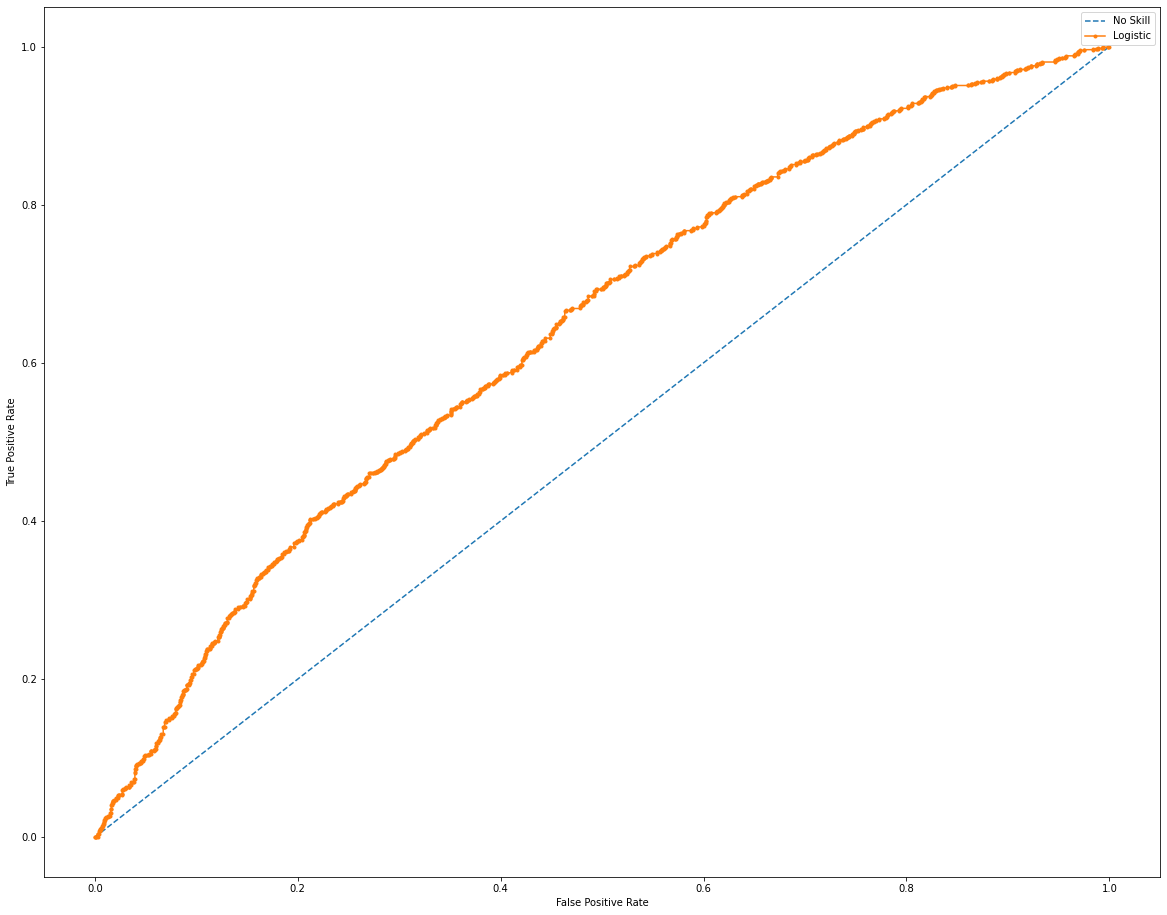

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = logit.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: f1=0.577 auc=0.581


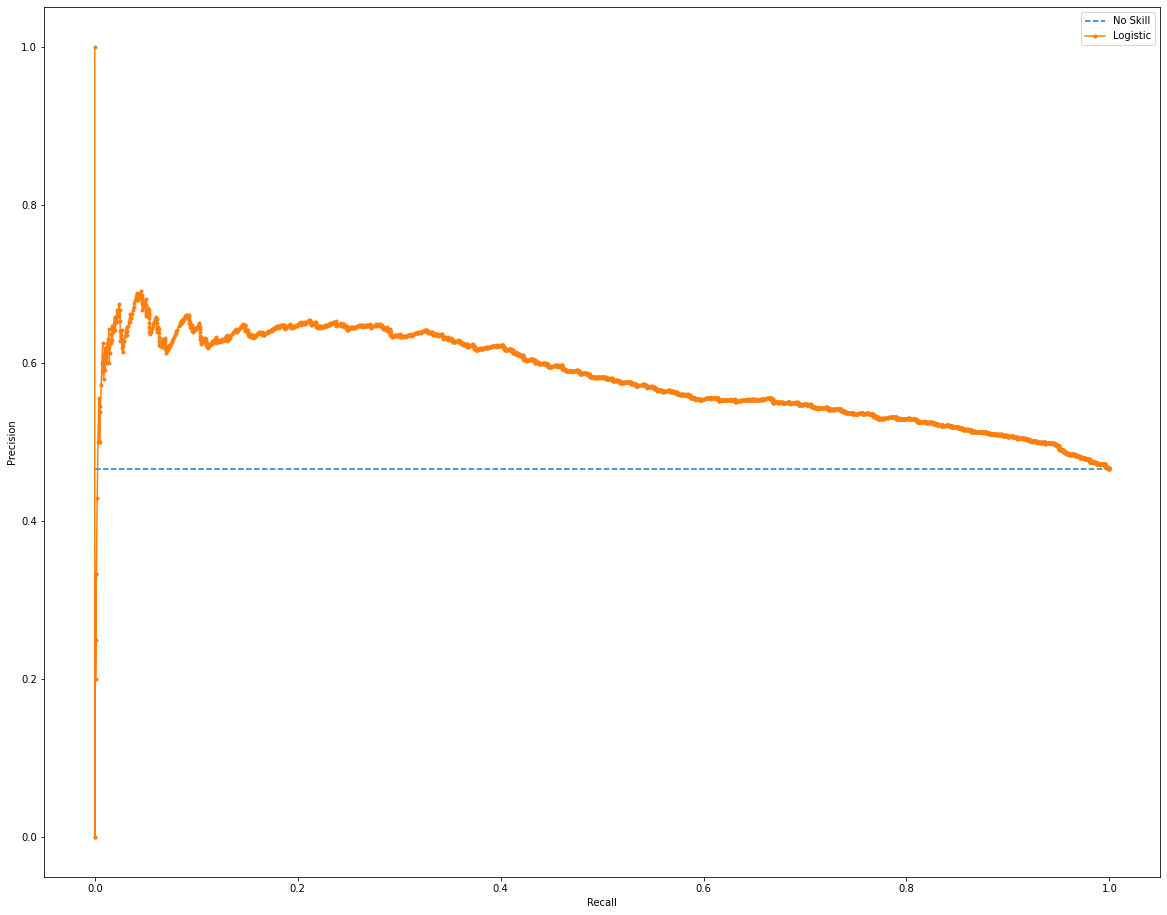

In [41]:
# precision-recall curve and f1

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc


# predict probabilities
lr_probs = logit.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = logit.predict(x_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

!apt-get update

In [42]:
import pickle
model_path = "logit_faceswap.pickle"
with open(model_path, 'rb') as fin:
    model = pickle.load(fin)

In [44]:
print(model.score(x_test, y_test))

0.5134643377001455
